In [6]:
import pandas as pd
import numpy as np

In [2]:
Combined3 = pd.read_csv('Combined3.csv')

In [3]:

all_cols = Combined3.columns.tolist()

mis_cols = Combined3.isna().sum().reset_index()
mis_cols.to_csv('missingdata_summary.csv')
latitude_cols = [k for k in all_cols if 'LAT' in k.upper()]
longitude_cols = [k for k in all_cols if 'LONG' in k.upper()]
depth_cols = [k for k in all_cols if 
              any(k for j in ['DEPTH','TD','TVD'] if str(j) in k.upper()) & 
              ('MW' not in k.upper())]

t2 = Combined3[depth_cols]
depth_cols = ['td_0', 'Total Vertical Depth (ft)_0.1']

In [4]:

def coalesce(df, column_names):
    i = iter(column_names)
    column_name = next(i)
    answer=df[column_name]
    for column_name in i:
        answer = answer.fillna(df[column_name])
    return answer

In [7]:

Combined3['CLS_Lat'] = coalesce(Combined3, latitude_cols)
Combined3['CLS_Long'] = coalesce(Combined3, longitude_cols)
Combined3['CLS_Depth_ft'] = coalesce(Combined3, depth_cols)
Combined3['fmtn'] = np.where(Combined3['UWI'].str.len()==16, 'DVN', 'EGB')

In [8]:
from pycaret.regression import *

In [15]:

labelcol = 'TrueTemp'
feature_cols = ['BHT','CLS_Lat', 'CLS_Long', 'CLS_Depth_ft', 'Krig_Temp']


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
import random
random.seed(10)
filterTraining = Combined3['Set']=='Training'
filterTesting = Combined3['Set']=='Validation_Testing'
all_train = Combined3[filterTraining].reset_index()
sample_rows = list(range(0,sum(filterTraining)))
train_rows = random.sample(sample_rows, int(len(sample_rows)*0.7))
train_rows.sort()
train = all_train[all_train.index.isin(train_rows)]
test = all_train[~all_train.index.isin(train_rows)]
validation_testing = Combined3[filterTesting]
train = Combined3.copy()
print(train.shape)
print(test.shape)

(836, 338)
(185, 339)


(array([  3.,  31.,  86., 145., 121., 153.,  46.,  16.,  10.,   4.]),
 array([  8.37      ,  27.13577778,  45.90155556,  64.66733333,
         83.43311111, 102.19888889, 120.96466667, 139.73044444,
        158.49622222, 177.262     , 196.02777778]),
 <a list of 10 Patch objects>)

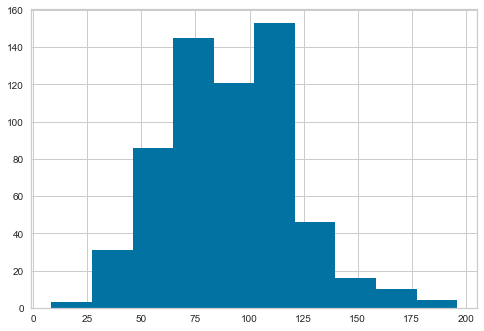

In [26]:
plt.hist(train[labelcol])

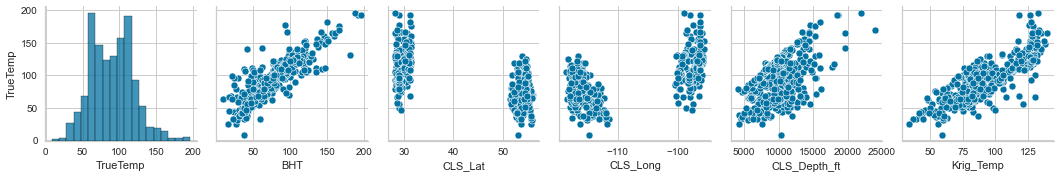

In [27]:
sns.pairplot(train, y_vars = labelcol, x_vars = train[[labelcol]+feature_cols].columns.values)


In [28]:
clf1 = setup(data=train[[labelcol]+feature_cols], target=labelcol, html=True, feature_selection=True)


,Description,Value
0,session_id,4900
1,Target,TrueTemp
2,Original Data,"(836, 6)"
3,Missing Values,True
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(432, 5)"


In [29]:
cm = compare_models(n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,8.7127,144.4060,11.8716,0.8197,0.1665,0.1234,0.0040
en,Elastic Net,8.7223,144.6414,11.8815,0.8194,0.1666,0.1235,0.0040
lasso,Lasso Regression,8.7204,144.6945,11.8835,0.8193,0.1667,0.1235,0.0040
lr,Linear Regression,8.7378,144.8057,11.8900,0.8192,0.1666,0.1235,0.3830
ridge,Ridge Regression,8.7377,144.8042,11.8899,0.8192,0.1666,0.1235,0.0040
lar,Least Angle Regression,8.7534,145.6511,11.9197,0.8184,0.1668,0.1236,0.0050
rf,Random Forest Regressor,7.5396,148.4132,11.9054,0.8176,0.1627,0.1078,0.0520
huber,Huber Regressor,8.5606,147.1094,11.9328,0.8164,0.1659,0.1187,0.0070
lightgbm,Light Gradient Boosting Machine,8.1276,152.5399,12.1977,0.8109,0.1646,0.1143,0.0160
et,Extra Trees Regressor,7.5756,159.5442,12.3810,0.8047,0.1693,0.1104,0.0450


In [50]:
cm[2]


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=4900,
      selection='cyclic', tol=0.0001, warm_start=False)

In [40]:
best_model = tune_model(cm[3])


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7.5641,117.5551,10.8423,0.8244,0.1537,0.1057
1,8.9610,152.5789,12.3523,0.7809,0.2913,0.2218
2,7.7690,98.7090,9.9352,0.8440,0.1364,0.1108
3,9.1813,133.3486,11.5477,0.8595,0.1593,0.1301
4,10.1685,208.2942,14.4324,0.6750,0.1751,0.1160
5,10.1628,216.5474,14.7155,0.7478,0.1889,0.1431
6,7.9761,133.9185,11.5723,0.8695,0.1386,0.0973
7,7.9932,113.2869,10.6436,0.8841,0.1377,0.0976
8,10.7468,195.7760,13.9920,0.8085,0.1634,0.1211
9,6.6411,75.0527,8.6633,0.9033,0.1176,0.0879


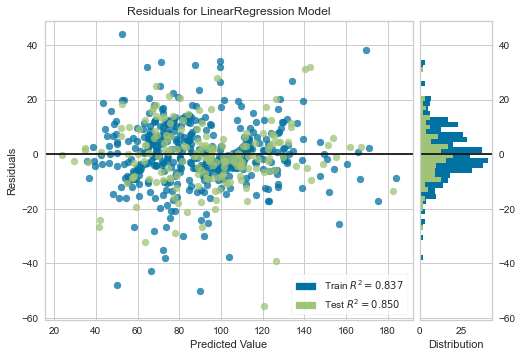

In [41]:
plot_model(best_model, plot='residuals')

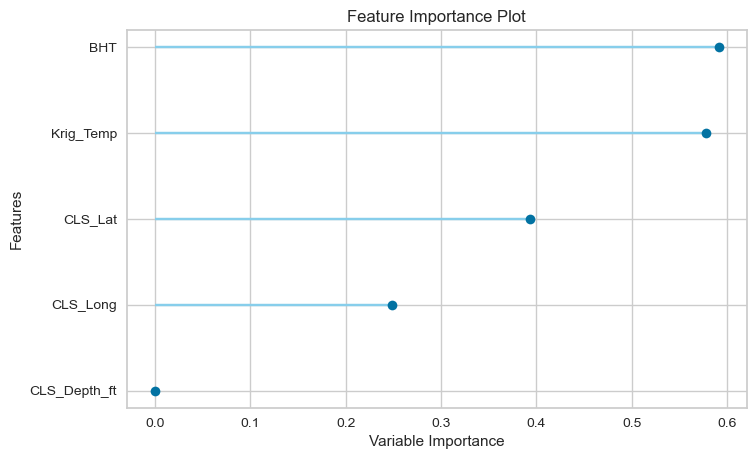

In [42]:
plot_model(best_model, plot='feature')

In [43]:
preds = predict_model(best_model, data = test)

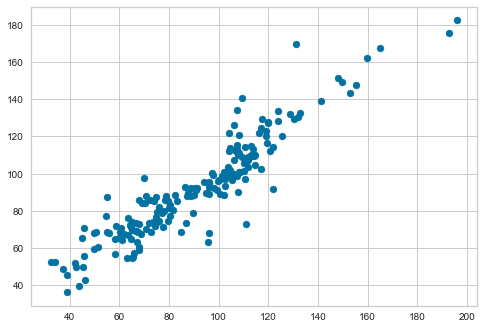

In [44]:
ax = plt.gca()
ax.scatter(preds[labelcol], preds['Label'])

In [45]:
from sklearn.metrics import mean_squared_error

In [46]:
error = abs(preds[labelcol]-preds['Label'])
print(np.mean(error))

7.908730629761576


In [47]:
print(100-np.mean(error/preds[labelcol]*100))

89.69256352016384
